# Preprocessing - Fraud Detection IBM

**Objectif** : Créer les features pour le modèle de détection de fraude.

**Stratégie Cold-Start** : Comme nous avons 100% de cold-start (0 client en commun train/eval), nous ne pouvons pas utiliser de features historiques par client. Nous nous concentrons sur :
- Features temporelles (hour, day_of_week, month)
- Features transactionnelles (amount, mcc, merchant)
- Encoding des variables catégorielles

## Imports et Configuration

In [430]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# Config
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Chemins
ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = ROOT / 'data'
OUTPUT_DIR = ROOT / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Workspace : {ROOT}")
print(f"Data directory : {DATA_DIR}")

Workspace : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2
Data directory : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2\data


## Chargement des Données

In [431]:
# Charger transactions
tx_train = pd.read_csv(DATA_DIR / 'transactions_train.csv')
print(f"Transactions train : {len(tx_train):,} lignes")

# Charger labels
with open(DATA_DIR / 'train_fraud_labels.json', 'r') as f:
    labels_data = json.load(f)
labels_raw = labels_data.get('target', labels_data)

# Normaliser labels Yes/No -> 1/0
labels = {str(k): 1 if str(v).lower() in ('yes', 'y', '1') else 0 
         for k, v in labels_raw.items()}
df_labels = pd.DataFrame([
    {'transaction_id': k, 'is_fraud': v} 
    for k, v in labels.items()
])

# Jointure
tx_train['transaction_id'] = tx_train['transaction_id'].astype(str)
tx = tx_train.merge(df_labels, on='transaction_id', how='left')

print(f"Labels joints : {tx['is_fraud'].notnull().sum():,}")
print(f"Taux de fraude : {tx['is_fraud'].mean()*100:.2f}%")
tx.head()

Transactions train : 210,000 lignes
Labels joints : 210,000
Taux de fraude : 0.15%


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN,0
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN,0
2,17566794,2016-03-26 12:42:00,1967,3367,$11.03,Chip Transaction,46978,Lake Forest,CA,92630.0,5411,NaN,0
3,17318690,2016-02-01 08:30:00,921,3457,$85.74,Chip Transaction,63701,Rush,NY,14543.0,5411,NaN,0
4,20994060,2018-03-24 14:42:00,456,2800,$13.43,Chip Transaction,83271,Estero,FL,33928.0,4214,NaN,0


In [432]:
# Charger les fichiers complémentaires
cards = pd.read_csv(DATA_DIR / 'cards_data.csv')
users = pd.read_csv(DATA_DIR / 'users_data.csv')

with open(DATA_DIR / 'mcc_codes.json', 'r') as f:
    mcc_map = json.load(f)

# Vérification
print(f"Cartes : {cards.shape}")
print(f"Utilisateurs : {users.shape}")
print(f"MCC Codes : {len(mcc_map)} entrées")


Cartes : (6146, 13)
Utilisateurs : (2000, 14)
MCC Codes : 109 entrées


In [433]:
# Harmoniser les noms de colonnes pour la fusion
cards.rename(columns={'id': 'card_id'}, inplace=True)
users.rename(columns={'id': 'client_id'}, inplace=True)

# Vérification rapide
print("Colonnes cartes :", cards.columns.tolist()[:10])
print("Colonnes utilisateurs :", users.columns.tolist()[:10])


Colonnes cartes : ['card_id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit']
Colonnes utilisateurs : ['client_id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income']


In [434]:
# Convertir les clés communes en string pour éviter les conflits
tx['card_id'] = tx['card_id'].astype(str)
tx['client_id'] = tx['client_id'].astype(str)
cards['card_id'] = cards['card_id'].astype(str)
users['client_id'] = users['client_id'].astype(str)

# Fusion
tx = tx.merge(cards, on='card_id', how='left', suffixes=('', '_card'))
tx = tx.merge(users, on='client_id', how='left', suffixes=('', '_user'))

# Ajouter la description du MCC
tx['mcc_description'] = tx['mcc'].map(mcc_map)

print(f"✅ Données fusionnées : {tx.shape}")


✅ Données fusionnées : (210000, 39)


## Feature Engineering

### 1. Parser les montants

In [435]:
# Age de la carte (si 'issue_date' ou 'expiry_date' existe)
if 'issue_date' in tx.columns:
    tx['issue_date'] = pd.to_datetime(tx['issue_date'], errors='coerce')
    tx['card_age_days'] = (pd.Timestamp.now() - tx['issue_date']).dt.days

# Si l'utilisateur a une info d'âge ou d'ancienneté
if 'user_birth_year' in tx.columns:
    tx['user_age'] = 2025 - tx['user_birth_year']

if 'credit_limit' in tx.columns:
    # Nettoyer et convertir en float
    tx['credit_limit'] = (
        tx['credit_limit']
        .replace('[^0-9.-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )
    tx['credit_limit_log'] = np.log1p(tx['credit_limit'])


if 'card_type' in tx.columns:
    le = LabelEncoder()
    tx['card_type_encoded'] = le.fit_transform(tx['card_type'].fillna('MISSING'))

if 'user_country' in tx.columns:
    le = LabelEncoder()
    tx['user_country_encoded'] = le.fit_transform(tx['user_country'].fillna('MISSING'))

if 'birth_year' in tx.columns and 'user_age' not in tx.columns:
    tx['user_age'] = 2025 - tx['birth_year']

if 'user_country' not in tx.columns:
    tx['user_country'] = 'UNKNOWN'
le_country = LabelEncoder()
tx['user_country_encoded'] = le_country.fit_transform(tx['user_country'].fillna('MISSING'))

if 'issue_date' in tx.columns:
    tx['issue_date'] = pd.to_datetime(tx['issue_date'], errors='coerce')
    tx['card_age_days'] = (pd.Timestamp.now() - tx['issue_date']).dt.days
else:
    tx['card_age_days'] = 0



In [436]:
def parse_amount(x):
    """Parser montant : remove $, commas, handle parentheses (negative)"""
    if pd.isna(x):
        return None
    s = str(x).strip()
    neg = False
    if s.startswith('(') and s.endswith(')'):
        neg = True
        s = s[1:-1]
    s = re.sub(r'[^0-9.\-]', '', s)
    if s == '':
        return None
    try:
        val = float(s)
        if neg:
            val = -abs(val)
        return val
    except Exception:
        return None

# Appliquer
tx['amount_parsed'] = tx['amount'].apply(parse_amount)
tx['amount_abs'] = tx['amount_parsed'].abs()
tx['is_negative_amount'] = (tx['amount_parsed'] < 0).astype(int)

print(f"Montants parsés : {tx['amount_parsed'].notnull().sum():,}")
print(f"Montants négatifs : {tx['is_negative_amount'].sum():,}")
print(f"Min : ${tx['amount_parsed'].min():.2f}")
print(f"Max : ${tx['amount_parsed'].max():.2f}")
print(f"Moyenne : ${tx['amount_parsed'].mean():.2f}")

# Contrôle des doublons
dupes = tx.duplicated(subset='transaction_id').sum()
print(f"Doublons détectés : {dupes}")
if dupes > 0:
    tx = tx.drop_duplicates(subset='transaction_id')
    print("Doublons supprimés.")

Montants parsés : 210,000
Montants négatifs : 10,128
Min : $-500.00
Max : $2775.67
Moyenne : $42.55
Doublons détectés : 0


### 2. Features temporelles

In [437]:
# Parser dates
tx['date_parsed'] = pd.to_datetime(tx['date'], errors='coerce')

# Extraire features temporelles
tx['hour'] = tx['date_parsed'].dt.hour
tx['day_of_week'] = tx['date_parsed'].dt.dayofweek  # 0=Lundi, 6=Dimanche
tx['day_of_month'] = tx['date_parsed'].dt.day
tx['month'] = tx['date_parsed'].dt.month
tx['is_weekend'] = (tx['day_of_week'] >= 5).astype(int)
tx['is_night'] = ((tx['hour'] >= 22) | (tx['hour'] <= 6)).astype(int)

print("Features temporelles créées :")
print(f"  hour : {tx['hour'].min()}-{tx['hour'].max()}")
print(f"  day_of_week : {tx['day_of_week'].min()}-{tx['day_of_week'].max()}")
print(f"  month : {tx['month'].min()}-{tx['month'].max()}")
print(f"  is_weekend : {tx['is_weekend'].sum():,} transactions")
print(f"  is_night : {tx['is_night'].sum():,} transactions")

Features temporelles créées :
  hour : 0-23
  day_of_week : 0-6
  month : 1-12
  is_weekend : 60,051 transactions
  is_night : 34,139 transactions


### 3. Features dérivées

In [438]:
# ZIP
tx['has_zip'] = (~tx['zip'].isna()).astype(int)

# Errors
tx['has_error'] = (~tx['errors'].isna()).astype(int)

print(f"Transactions avec ZIP : {tx['has_zip'].sum():,} ({tx['has_zip'].mean()*100:.1f}%)")
print(f"Transactions avec erreur : {tx['has_error'].sum():,} ({tx['has_error'].mean()*100:.1f}%)")

Transactions avec ZIP : 183,203 (87.2%)
Transactions avec erreur : 3,273 (1.6%)


### 4. Encoding des variables catégorielles

In [439]:
# Variables catégorielles à encoder
categorical_cols = ['mcc', 'merchant_id', 'use_chip', 'merchant_city', 'merchant_state']

label_encoders = {}

for col in categorical_cols:
    if col not in tx.columns:
        continue
    
    # Remplir les valeurs manquantes
    tx[col] = tx[col].fillna('MISSING')
    
    # Encoder
    le = LabelEncoder()
    tx[f'{col}_encoded'] = le.fit_transform(tx[col].astype(str))
    label_encoders[col] = le
    
    print(f"{col} : {len(le.classes_)} catégories uniques")

print(f"\nLabel encoders sauvegardés : {len(label_encoders)}")

mcc : 109 catégories uniques
merchant_id : 13576 catégories uniques
use_chip : 3 catégories uniques
merchant_city : 5472 catégories uniques
merchant_state : 123 catégories uniques

Label encoders sauvegardés : 5


## Gestion des Valeurs Manquantes

In [440]:
# Avant
print("Valeurs manquantes AVANT imputation :")
missing_before = tx[['amount_parsed', 'amount_abs', 'hour', 'day_of_week', 'month']].isnull().sum()
print(missing_before[missing_before > 0])

# Imputation
# Montants : remplacer par médiane
median_amount = tx['amount_parsed'].median()
tx['amount_parsed'] = tx['amount_parsed'].fillna(median_amount)
tx['amount_abs'] = tx['amount_abs'].fillna(median_amount)

# Temporelles : remplacer par médiane
for col in ['hour', 'day_of_week', 'day_of_month', 'month']:
    if col in tx.columns:
        tx[col] = tx[col].fillna(tx[col].median())

# Après
print("\nValeurs manquantes APRÈS imputation :")
missing_after = tx[['amount_parsed', 'amount_abs', 'hour', 'day_of_week', 'month']].isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "Aucune")

Valeurs manquantes AVANT imputation :
Series([], dtype: int64)

Valeurs manquantes APRÈS imputation :
Aucune


## Sélection des Features Finales

In [441]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tx[['amount_parsed', 'amount_abs']] = scaler.fit_transform(
    tx[['amount_parsed', 'amount_abs']]
)

# Features pour le modèle
feature_cols = [
    # Temporelles
    'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night',
    # Montants
    'amount_parsed', 'amount_abs', 'is_negative_amount',
    # Côté commerçant
    'mcc_encoded', 'merchant_id_encoded', 'use_chip_encoded',
    'merchant_city_encoded', 'merchant_state_encoded',
    # Nouvelles features
    'has_zip', 'has_error', 'card_type_encoded', 'credit_limit_log',
    'user_age', 'user_country_encoded', 'card_age_days'
]

missing_features = [c for c in ['user_age', 'user_country_encoded', 'card_age_days'] if c not in tx.columns]
print("Colonnes manquantes :", missing_features)

# Vérifier quelles features existent
available_features = [col for col in feature_cols if col in tx.columns]

# Dataset final
tx_processed = tx[available_features + ['is_fraud', 'transaction_id']].copy()

print(f"Dataset final :")
print(f"  Transactions : {len(tx_processed):,}")
print(f"  Features : {len(available_features)}")
print(f"  Shape : {tx_processed.shape}")
print(f"\nFeatures sélectionnées :")
for i, feat in enumerate(available_features, 1):
    print(f"  {i:2d}. {feat}")

Colonnes manquantes : []
Dataset final :
  Transactions : 210,000
  Features : 21
  Shape : (210000, 23)

Features sélectionnées :
   1. hour
   2. day_of_week
   3. day_of_month
   4. month
   5. is_weekend
   6. is_night
   7. amount_parsed
   8. amount_abs
   9. is_negative_amount
  10. mcc_encoded
  11. merchant_id_encoded
  12. use_chip_encoded
  13. merchant_city_encoded
  14. merchant_state_encoded
  15. has_zip
  16. has_error
  17. card_type_encoded
  18. credit_limit_log
  19. user_age
  20. user_country_encoded
  21. card_age_days


## Statistiques Finales

In [442]:
print("="*60)
print("RÉSUMÉ PREPROCESSING")
print("="*60)

print(f"\nDonnées :")
print(f"  Transactions : {len(tx_processed):,}")
print(f"  Features : {len(available_features)}")

print(f"\nTarget (is_fraud) :")
fraud_count = tx_processed['is_fraud'].sum()
normal_count = (tx_processed['is_fraud'] == 0).sum()
fraud_rate = tx_processed['is_fraud'].mean() * 100
print(f"  Fraudes : {fraud_count:,} ({fraud_rate:.2f}%)")
print(f"  Normales : {normal_count:,} ({100-fraud_rate:.2f}%)")
print(f"  Ratio déséquilibre : 1:{normal_count/fraud_count:.1f}")

print(f"\nValeurs manquantes :")
missing_final = tx_processed[available_features].isnull().sum()
if missing_final.sum() > 0:
    print(missing_final[missing_final > 0])
else:
    print("  Aucune valeur manquante")

# Stats descriptives
print(f"\nStatistiques des features numériques :")
tx_processed[available_features].describe()

RÉSUMÉ PREPROCESSING

Données :
  Transactions : 210,000
  Features : 21

Target (is_fraud) :
  Fraudes : 315 (0.15%)
  Normales : 209,685 (99.85%)
  Ratio déséquilibre : 1:665.7

Valeurs manquantes :
  Aucune valeur manquante

Statistiques des features numériques :


,hour,day_of_week,day_of_month,month,is_weekend,is_night,amount_parsed,amount_abs,is_negative_amount,mcc_encoded,merchant_id_encoded,use_chip_encoded,merchant_city_encoded,merchant_state_encoded,has_zip,has_error,card_type_encoded,credit_limit_log,user_age,user_country_encoded,card_age_days
count,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,2.100000e+05,2.100000e+05,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.0,210000.0
mean,12.271248,3.014195,15.712614,6.538005,0.285957,0.162567,1.682971e-16,3.671476e-16,0.048229,59.954081,6078.559476,0.448276,2753.585424,59.723724,0.872395,0.015586,0.784671,9.060044,59.753629,0.0,0.0
std,5.083351,1.985098,8.820309,3.448550,0.451870,0.368971,1.000002e+00,1.000002e+00,0.214249,15.896274,3721.792450,0.758503,1486.582605,33.245611,0.333650,0.123866,0.560214,1.665765,15.927236,0.0,0.0
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-6.725661e+00,-7.018602e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.0,0.0
25%,8.000000,1.000000,8.000000,4.000000,0.000000,0.000000,-4.192794e-01,-5.483485e-01,0.000000,53.000000,2679.000000,0.000000,1465.000000,33.000000,1.000000,0.000000,0.000000,8.987322,48.000000,0.0,0.0
50%,12.000000,3.000000,16.000000,7.000000,0.000000,0.000000,-1.782949e-01,-2.511707e-01,0.000000,57.000000,5988.000000,0.000000,3038.000000,60.000000,1.000000,0.000000,1.000000,9.512665,58.000000,0.0,0.0
75%,16.000000,5.000000,23.000000,10.000000,1.000000,0.000000,2.442958e-01,2.255394e-01,0.000000,70.000000,9148.000000,1.000000,3730.000000,82.000000,1.000000,0.000000,1.000000,9.948174,69.000000,0.0,0.0
max,23.000000,6.000000,31.000000,12.000000,1.000000,1.000000,3.388061e+01,3.647946e+01,1.000000,108.000000,13575.000000,2.000000,5471.000000,122.000000,1.000000,1.000000,2.000000,11.859291,107.000000,0.0,0.0


## Export des Données Preprocessées

In [443]:
# Sauvegarder le dataset preprocessé
output_path = OUTPUT_DIR / 'train_processed.csv'
tx_processed.to_csv(output_path, index=False)

print(f"Données preprocessées exportées : {output_path}")
print(f"Taille : {output_path.stat().st_size / 1024 / 1024:.1f} MB")
print(f"Shape : {tx_processed.shape}")

# Sauvegarder aussi les label encoders pour réutilisation
import pickle
encoders_path = OUTPUT_DIR / 'label_encoders.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"\nLabel encoders sauvegardés : {encoders_path}")

Données preprocessées exportées : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2\output\train_processed.csv
Taille : 23.4 MB
Shape : (210000, 23)

Label encoders sauvegardés : c:\Users\romai\Documents\ESILV - Année 2025-2026\Hackaton\hackaton_finance_team2\output\label_encoders.pkl


## Visualisations

### Distribution des features par classe

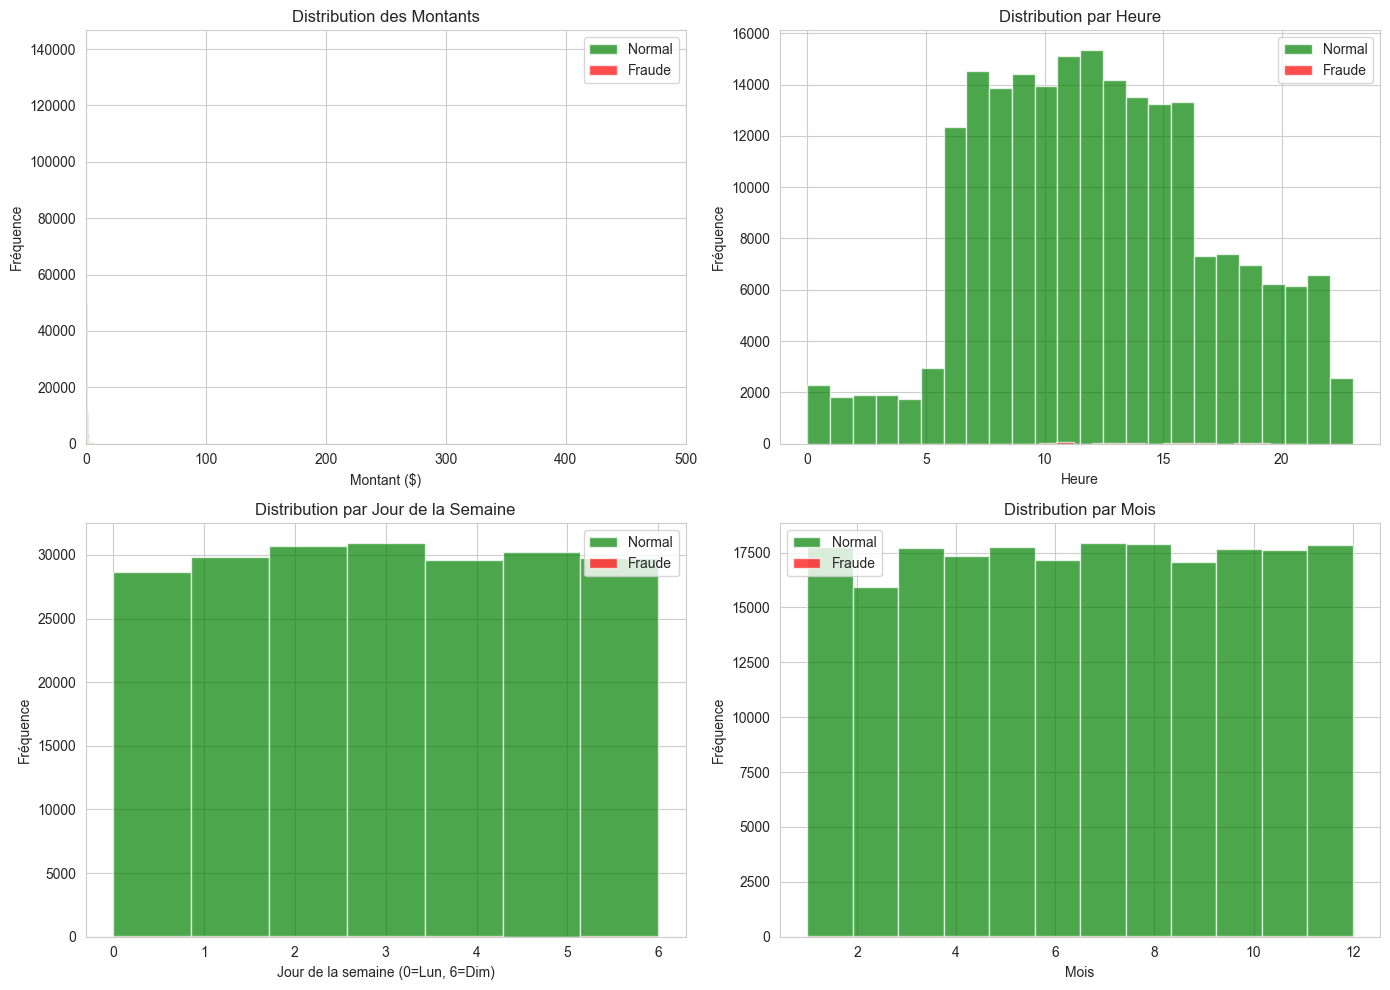

In [444]:
# Montant par classe
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Montant
tx_processed[tx_processed['is_fraud'] == 0]['amount_abs'].hist(bins=50, alpha=0.7, label='Normal', ax=axes[0, 0], color='green')
tx_processed[tx_processed['is_fraud'] == 1]['amount_abs'].hist(bins=50, alpha=0.7, label='Fraude', ax=axes[0, 0], color='red')
axes[0, 0].set_xlabel('Montant ($)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Montants')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 500)

# Heure
tx_processed[tx_processed['is_fraud'] == 0]['hour'].hist(bins=24, alpha=0.7, label='Normal', ax=axes[0, 1], color='green')
tx_processed[tx_processed['is_fraud'] == 1]['hour'].hist(bins=24, alpha=0.7, label='Fraude', ax=axes[0, 1], color='red')
axes[0, 1].set_xlabel('Heure')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution par Heure')
axes[0, 1].legend()

# Jour de la semaine
tx_processed[tx_processed['is_fraud'] == 0]['day_of_week'].hist(bins=7, alpha=0.7, label='Normal', ax=axes[1, 0], color='green')
tx_processed[tx_processed['is_fraud'] == 1]['day_of_week'].hist(bins=7, alpha=0.7, label='Fraude', ax=axes[1, 0], color='red')
axes[1, 0].set_xlabel('Jour de la semaine (0=Lun, 6=Dim)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution par Jour de la Semaine')
axes[1, 0].legend()

# Mois
tx_processed[tx_processed['is_fraud'] == 0]['month'].hist(bins=12, alpha=0.7, label='Normal', ax=axes[1, 1], color='green')
tx_processed[tx_processed['is_fraud'] == 1]['month'].hist(bins=12, alpha=0.7, label='Fraude', ax=axes[1, 1], color='red')
axes[1, 1].set_xlabel('Mois')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution par Mois')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

C:\Users\romai\AppData\Local\Temp\ipykernel_47680\3057915915.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=tx_processed, palette=['green', 'red'])


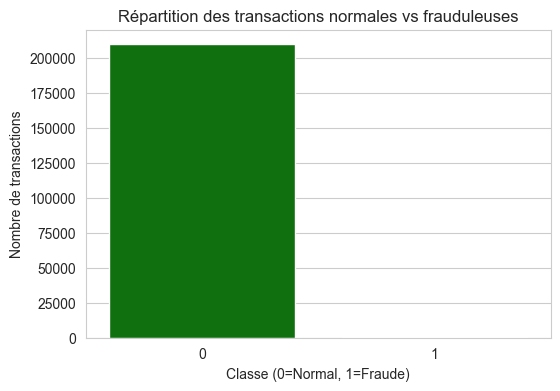

In [445]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=tx_processed, palette=['green', 'red'])
plt.title('Répartition des transactions normales vs frauduleuses')
plt.xlabel('Classe (0=Normal, 1=Fraude)')
plt.ylabel('Nombre de transactions')
plt.show()


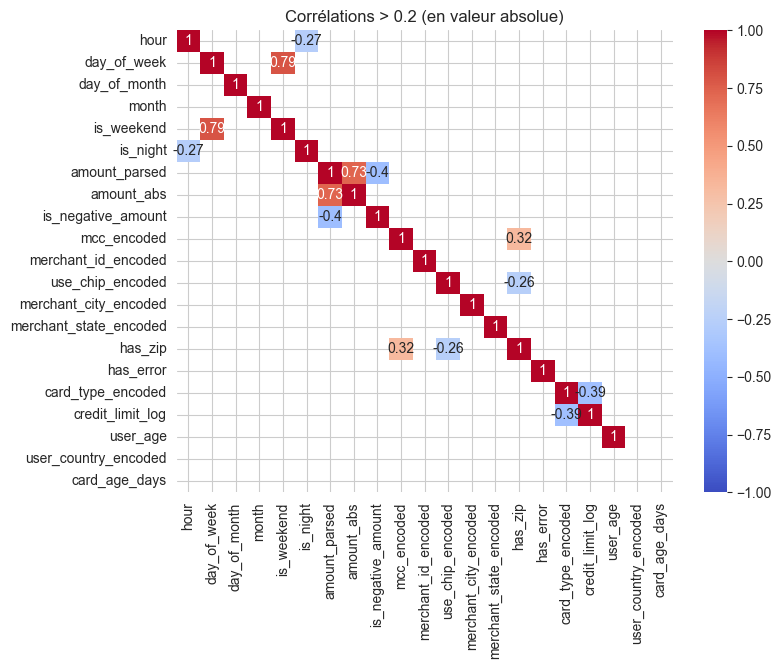

In [446]:
corr = tx_processed[feature_cols].corr()
mask = corr.abs() > 0.2  # seuil de pertinence
plt.figure(figsize=(8,6))
sns.heatmap(corr.where(mask), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrélations > 0.2 (en valeur absolue)')
plt.show()


C:\Users\romai\AppData\Local\Temp\ipykernel_47680\425300898.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')


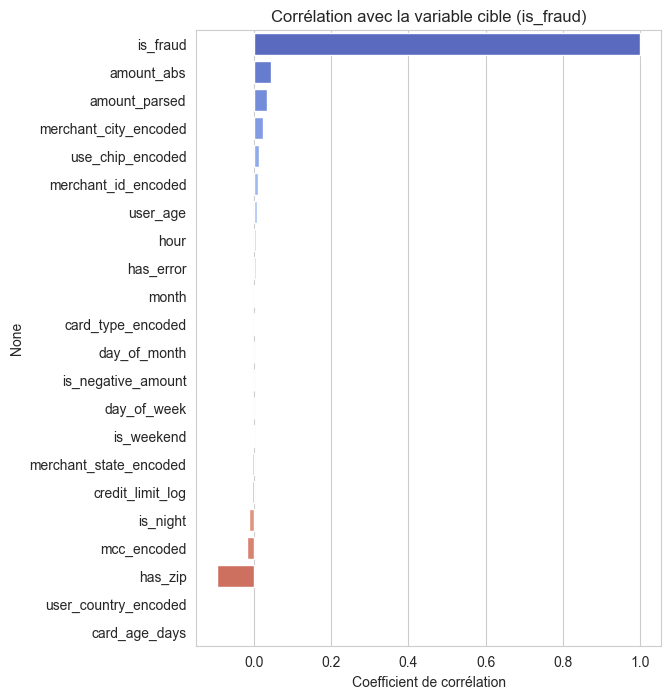

In [447]:
corr = tx_processed[feature_cols + ['is_fraud']].corr()['is_fraud'].sort_values(ascending=False)
plt.figure(figsize=(6,8))
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
plt.title('Corrélation avec la variable cible (is_fraud)')
plt.xlabel('Coefficient de corrélation')
plt.show()


Cette heatmap montre que la fraude n’est que très faiblement corrélée avec les variables disponibles, ce qui indique un problème complexe et non linéaire. Les montants (amount_parsed, amount_abs) et certains codes marchands ou villes ont un léger lien avec la fraude, mais aucun indicateur simple ne permet de la prédire directement — il faudra donc un modèle d’apprentissage supervisé plus avancé (comme un Random Forest ou un Gradient Boosting).

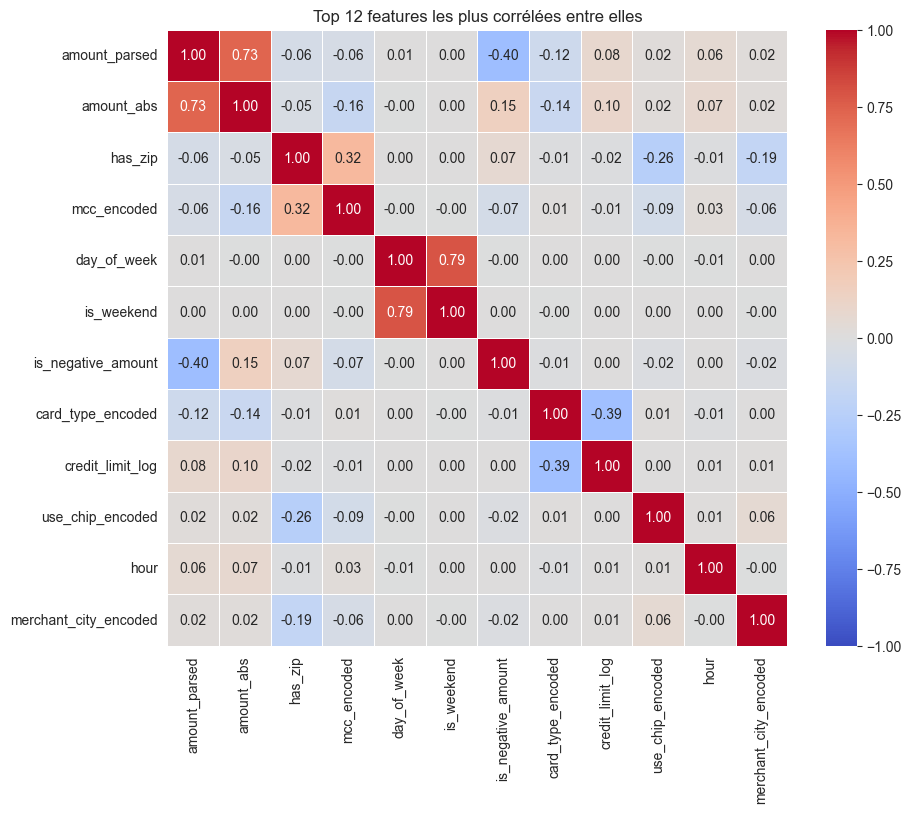

In [448]:
corr = tx_processed[feature_cols].corr()

# Moyenne absolue des corrélations
mean_corr = corr.abs().mean().sort_values(ascending=False)
top_features = mean_corr.head(12).index  # élargir un peu la sélection

plt.figure(figsize=(10,8))
sns.heatmap(
    tx_processed[top_features].corr(),
    annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5
)
plt.title('Top 12 features les plus corrélées entre elles')
plt.show()

In [449]:
# Identifier les paires trop corrélées (|corr| > 0.9)
high_corr_pairs = corr[(abs(corr) > 0.9) & (abs(corr) < 1)]
print("Paires fortement corrélées (>|0.9|) :")
print(high_corr_pairs.stack().sort_values(ascending=False))


Paires fortement corrélées (>|0.9|) :
Series([], dtype: float64)


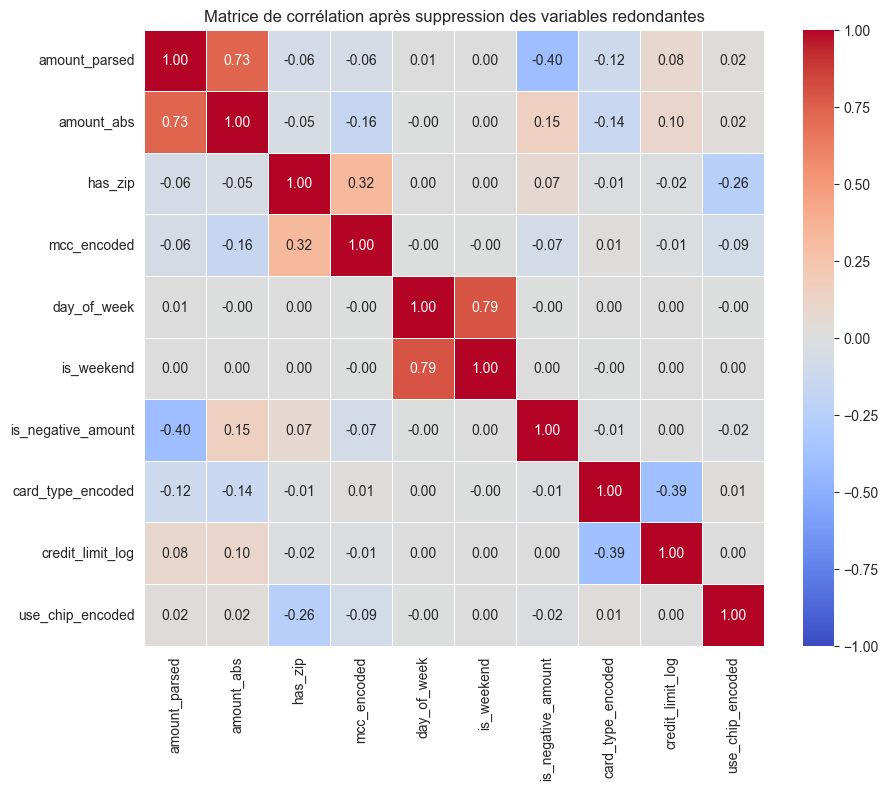

In [450]:
corr = tx_processed[feature_cols].corr()

# Moyenne des corrélations par variable
mean_corr = corr.abs().mean().sort_values(ascending=False)
top_features = mean_corr.head(10).index

plt.figure(figsize=(10,8))
sns.heatmap(
    tx_processed[top_features].corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".2f",  # deux décimales
    linewidths=0.5
)
plt.title('Top 10 features les plus corrélées entre elles (après nettoyage)')
plt.title("Matrice de corrélation après suppression des variables redondantes")
plt.show()

C:\Users\romai\AppData\Local\Temp\ipykernel_47680\3618657436.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


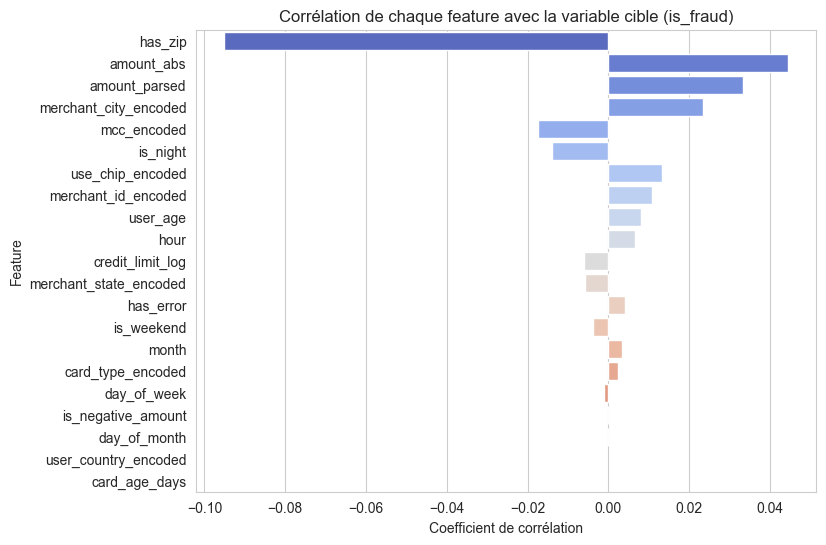

Top 15 corrélations avec la variable cible :

has_zip                  -0.095074
amount_abs                0.044450
amount_parsed             0.033326
merchant_city_encoded     0.023498
mcc_encoded              -0.017467
is_night                 -0.014076
use_chip_encoded          0.013268
merchant_id_encoded       0.010778
user_age                  0.008155
hour                      0.006476
credit_limit_log         -0.006161
merchant_state_encoded   -0.005681
has_error                 0.004063
is_weekend               -0.003833
month                     0.003337
Name: is_fraud, dtype: float64


In [451]:
# Corrélation avec la variable cible
target_corr = (
    tx_processed[feature_cols + ['is_fraud']]
    .corr()['is_fraud']
    .drop('is_fraud')
    .sort_values(key=abs, ascending=False)
)

plt.figure(figsize=(8,6))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette='coolwarm'
)
plt.title("Corrélation de chaque feature avec la variable cible (is_fraud)")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Feature")
plt.show()

print("Top 15 corrélations avec la variable cible :\n")
print(target_corr.head(15))


Forte multicolinéarité entre quelques variables dérivées (amount_parsed, amount_abs, day_of_week, is_weekend).
→ À réduire avant entraînement.

Faibles corrélations globales sinon, donc les autres variables apportent de l’information indépendante.

Variables pertinentes à garder : amount_abs, is_negative_amount, hour, use_chip_encoded, mcc_encoded, has_zip.

In [452]:
from imblearn.over_sampling import BorderlineSMOTE

X = tx_processed[feature_cols]
y = tx_processed['is_fraud']
X = X.astype('float32')


bsmote = BorderlineSMOTE(sampling_strategy=0.2, random_state=42, kind='borderline-1')
X_res, y_res = bsmote.fit_resample(X, y)

int_cols = ['hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night']
for col in int_cols:
    if col in X_res.columns:
        X_res[col] = X_res[col].round().astype('Int32')


print("Avant rééchantillonnage :", y.value_counts())
print("Après Borderline-SMOTE :", y_res.value_counts())


Avant rééchantillonnage : is_fraud
0    209685
1       315
Name: count, dtype: int64
Après Borderline-SMOTE : is_fraud
0    209685
1     41937
Name: count, dtype: int64


C:\Users\romai\AppData\Local\Temp\ipykernel_47680\3704537930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette=['#2ecc71','#e74c3c'])


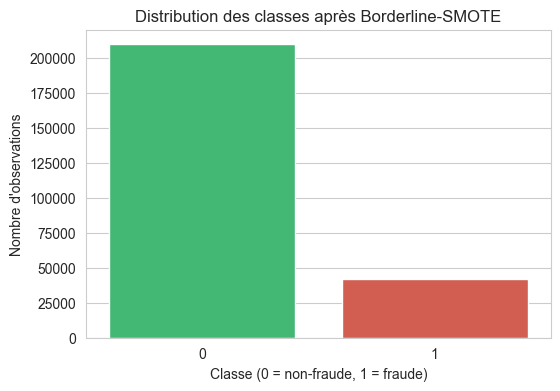

In [453]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_res, palette=['#2ecc71','#e74c3c'])
plt.title("Distribution des classes après Borderline-SMOTE")
plt.xlabel("Classe (0 = non-fraude, 1 = fraude)")
plt.ylabel("Nombre d'observations")
plt.show()

In [454]:
# Calculer la corrélation de chaque feature avec la variable cible
target_corr = (
    tx_processed[feature_cols + ['is_fraud']]
    .corr()['is_fraud']
    .drop('is_fraud')
)

# Sélectionner les features ayant une corrélation modérée avec la cible
selected_features = target_corr[(target_corr.abs() <= 0.5)].index.tolist()

print(f"Nombre de features retenues : {len(selected_features)}")
print("Features sélectionnées :")
print(selected_features)

# Construire le DataFrame équilibré avec ces features
final_df = pd.concat([X_res[selected_features], y_res], axis=1)

# Convertir les colonnes catégorielles en Int32
cat_cols = [
    'has_zip', 'merchant_city_encoded', 'mcc_encoded',
    'use_chip_encoded', 'merchant_id_encoded',
    'merchant_state_encoded', 'has_error'
]

for col in cat_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].round().astype('Int32')

print("\nTypes finaux des colonnes :")
print(final_df.dtypes)


Nombre de features retenues : 19
Features sélectionnées :
['hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night', 'amount_parsed', 'amount_abs', 'is_negative_amount', 'mcc_encoded', 'merchant_id_encoded', 'use_chip_encoded', 'merchant_city_encoded', 'merchant_state_encoded', 'has_zip', 'has_error', 'card_type_encoded', 'credit_limit_log', 'user_age']

Types finaux des colonnes :
hour                        Int32
day_of_week                 Int32
day_of_month                Int32
month                       Int32
is_weekend                  Int32
is_night                    Int32
amount_parsed             float32
amount_abs                float32
is_negative_amount        float32
mcc_encoded                 Int32
merchant_id_encoded         Int32
use_chip_encoded            Int32
merchant_city_encoded       Int32
merchant_state_encoded      Int32
has_zip                     Int32
has_error                   Int32
card_type_encoded         float32
credit_limit_log     

In [455]:
final_df.to_csv(OUTPUT_DIR / 'processed_data.csv', index=False)